# Importing required packages

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, json

# Loading inference data

* Loading and checking raw data

In [2]:
raw_inference_data = pd.read_csv('testdf.csv', sep=';')
raw_inference_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125395 entries, 0 to 125394
Data columns (total 51 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Offset                                       125395 non-null  float64
 1   Engine RPM (SAE)                             125395 non-null  float64
 2   Knock Retard Degree Long Term                125395 non-null  int64  
 3   Accelerator Pedal Position Sensor Voltage    125395 non-null  float64
 4   Throttle Position (SAE) %                    125395 non-null  float64
 5   Relative Throttle Position (SAE) %           125395 non-null  float64
 6   Commanded Throttle Actuator (SAE) %          125395 non-null  float64
 7   Fuel System #1 Status (SAE)                  125395 non-null  object 
 8   Fuel System #2 Status (SAE)                  125395 non-null  object 
 9   Injector Pulse Width Average ms              125395 non-nul

* Omitting noise and unnecessary columns

In [3]:
filtered_inference_data = raw_inference_data.iloc[8400:,[1, 3, 4, 9, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50]]

renamed_inference_data = filtered_inference_data.rename(columns={'Engine RPM (SAE)': 'rpm',
                                        'Throttle Position (SAE) %': 'throttle_percent',
                                        'Injector Pulse Width Average ms': 'inj_pulse_width_avg_ms',
                                        'Timing Advance Degree (SAE)': 'timing_advance_deg',
                                        'Total Knock Retard Degree': 'total_knock_ret_deg',
                                        'Idle Desired RPM': 'idle_desired_rpm',
                                        'Vehicle Speed (SAE) km/h': 'kmh',
                                        'Absolute Load (SAE) %': 'absolute_load_percent',
                                        'Exhaust Gas Temperature C°': 'exh_temp_celsius',
                                        'Engine Coolant Temp (SAE) C°': 'coolant_temp_celsius',
                                        'Intake Air Temp (SAE) C°': 'intake_air_temp_celsius',
                                        'Manifold Air Temp C°': 'manifold_air_temp_celsius',
                                        'Barometric Pressure kPa': 'barometric_pressure_kpa',
                                        'Ambient Air Temp (SAE) C°': 'ambient_air_temp_celsius',
                                        'Total Airflow g/s': 'total_airflow_grampersecond',
                                        'Total Volumetric Efficiency Bank 1 %': 'total_ve_bank_1_percent',
                                        'Base Volumetric Efficiency Bank 1 %': 'base_ve_bank_1_percent',
                                        'Intake Manifold Absolute Pressure (SAE) kPa': 'absolute_in_manifold_pressure_kpa',
                                        'Fuel Mass Cyl 1 Gramm': 'fuel_mass_cyl1_gramm',
                                        'Pressure Ratio': 'pratio',
                                        'Aircharge mg': 'aircharge_milligram'})


renamed_inference_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116995 entries, 8400 to 125394
Data columns (total 36 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   rpm                                        116995 non-null  float64
 1   Accelerator Pedal Position Sensor Voltage  116995 non-null  float64
 2   throttle_percent                           116995 non-null  float64
 3   inj_pulse_width_avg_ms                     116995 non-null  float64
 4   total_knock_ret_deg                        116995 non-null  float64
 5   Long Term Fuel Trim Bank 1 (SAE) %         116995 non-null  float64
 6   Short Term Fuel Trim Bank 2 (SAE) %        116995 non-null  float64
 7   Engine Torque Losses                       116995 non-null  float64
 8   Short Term Fuel Trim Bank 1 (SAE) %        116995 non-null  float64
 9   timing_advance_deg                         116995 non-null  float64
 10  Knock

* Saving as csv for future loading/editing

In [4]:
renamed_inference_data
renamed_inference_data.to_csv('testdf_filtered.csv', sep=';')

* Correleation heatmap of the df

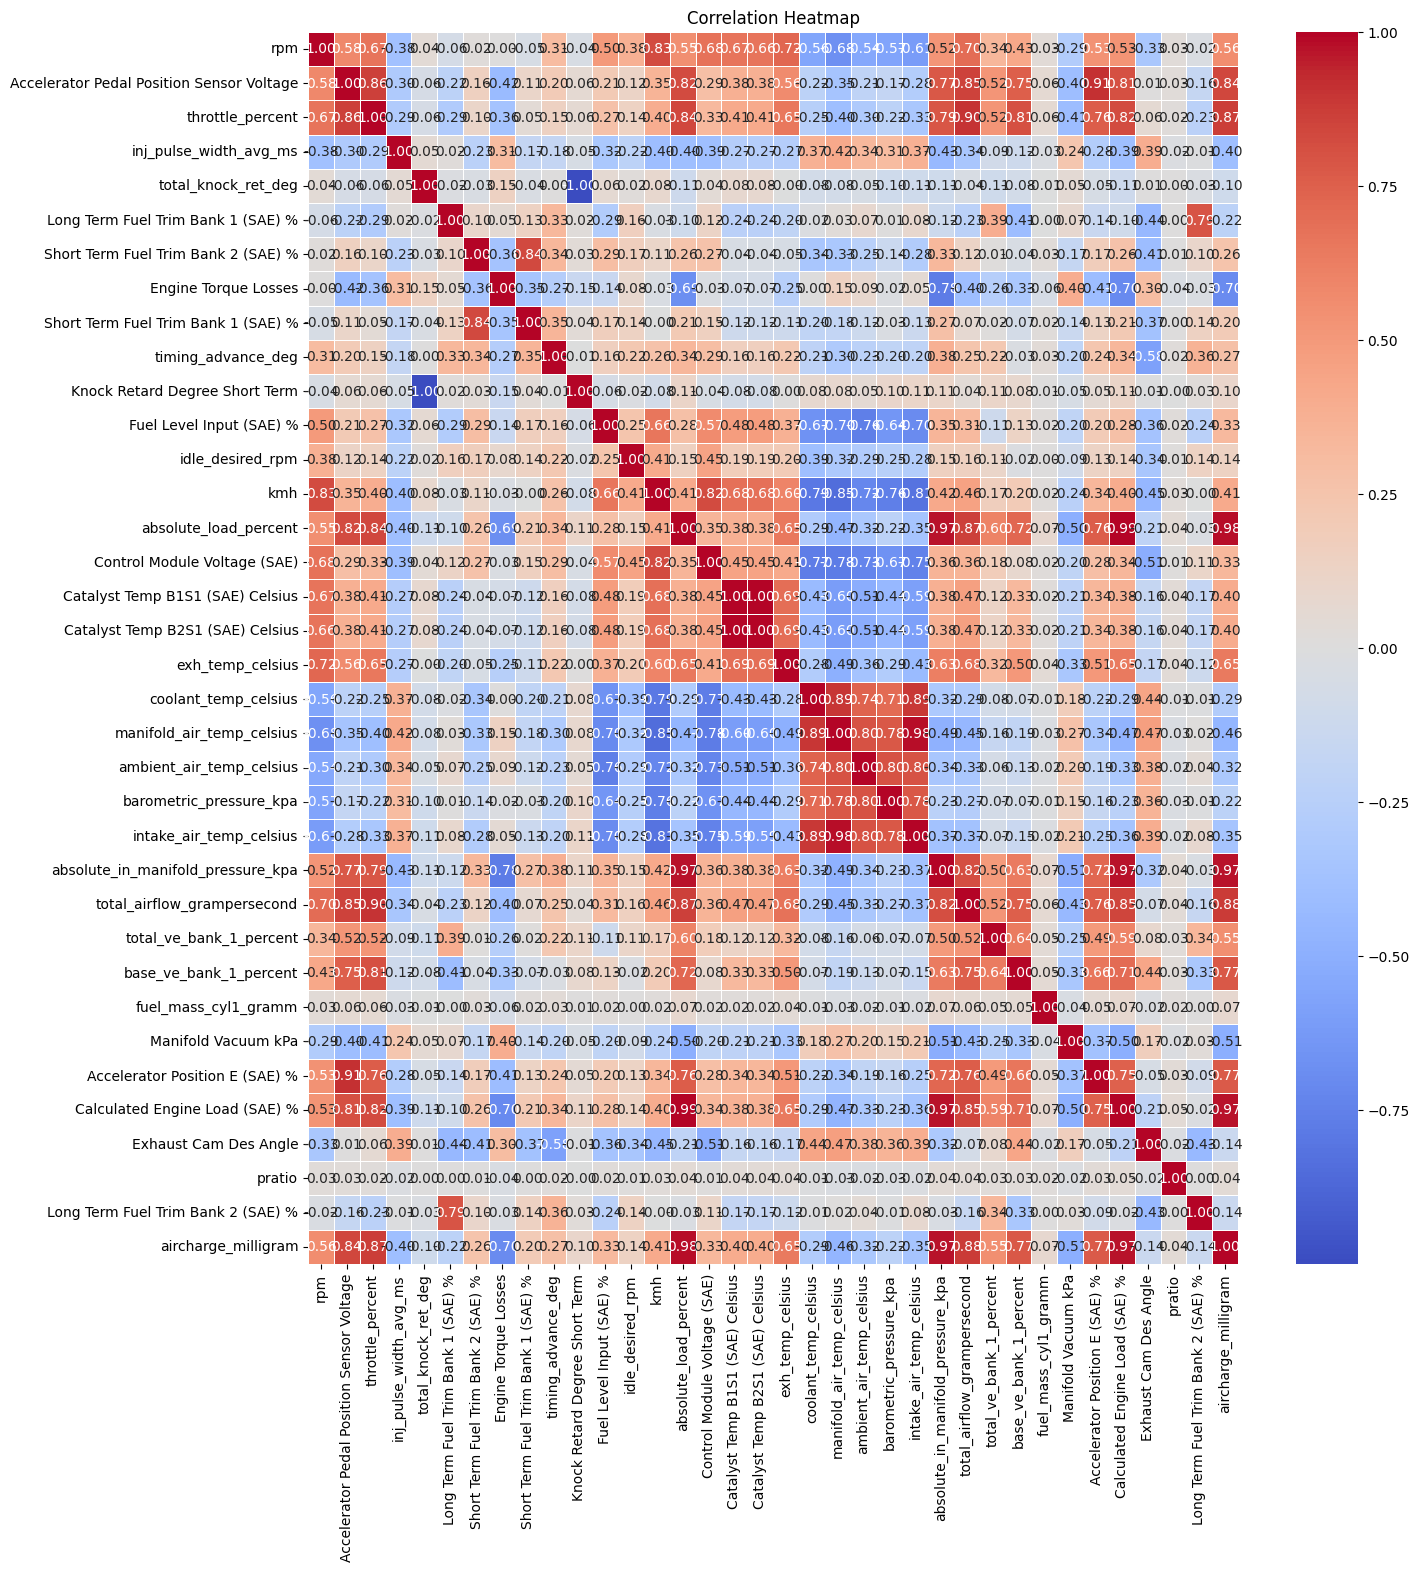

In [6]:
matrix = renamed_inference_data.corr()
plt.figure(figsize=(15,16))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

* Only keeping columns for inference

In [7]:
correlation_dataset = renamed_inference_data[['rpm', 'exh_temp_celsius', 'total_airflow_grampersecond', 'aircharge_milligram']]

# saving for future potential editing or troubleshooting
correlation_dataset.to_csv('correlation_dataset.csv', sep=';')

* Correlation matrix of inference data

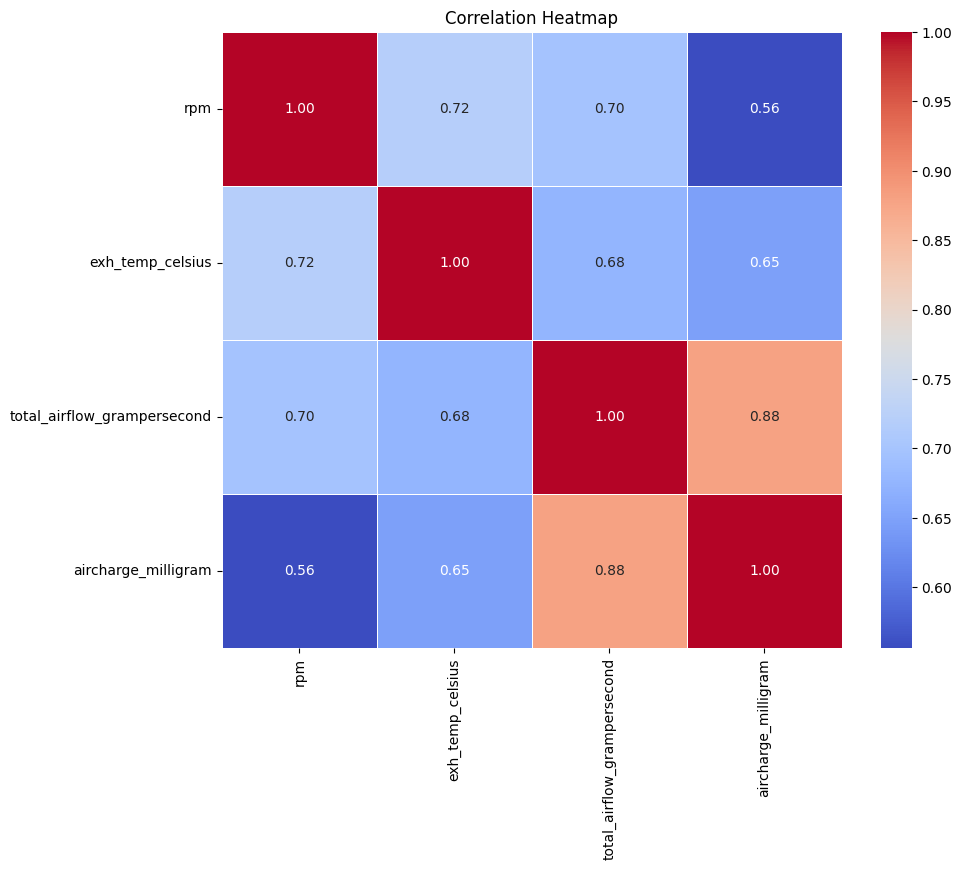

In [8]:
matrix = correlation_dataset.corr()

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Loading model data

* Loading scripted module

In [9]:
ts_model = torch.jit.load("vemodel_scripted.pt", map_location="cpu")
ts_model.eval()
# loading scaler and features used during training for data preprocessing
scaler = joblib.load("x_scaler.pkl")
FEATURES = json.load(open("features.json"))

In [10]:
# Preprocess inputs exactly like training
X_np_raw = correlation_dataset.to_numpy().astype(np.float32)
X_np = scaler.transform(X_np_raw).astype(np.float32)
x_t = torch.from_numpy(X_np)

# 3) Inference
with torch.no_grad():
    y_pred = ts_model(x_t).squeeze(-1).cpu().numpy()

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
X_np_raw

array([[1705.2467   ,  659.       ,   34.804688 ,  276.       ],
       [1705.622    ,  659.       ,   34.76953  ,  280.       ],
       [1706.0242   ,  659.       ,   35.26367  ,  281.8      ],
       ...,
       [ 706.       ,  484.       ,    5.397461 ,  115.       ],
       [ 706.       ,  484.       ,    5.1660156,  114.6      ],
       [ 706.       ,  484.       ,    5.1660156,  114.4      ]],
      dtype=float32)

# Visualizing inference

In [12]:
# Axes from UNscaled test features
rpm        = X_np_raw[:, 0]
exh_temp   = X_np_raw[:, 1]
airflow_gs = X_np_raw[:, 2]
aircharge  = X_np_raw[:, 3]

Z = np.asarray(y_pred, dtype=np.float32)   # VE (%)

# Clip for nicer colorbar
Z = np.clip(Z, 0, 140)

/var/folders/zg/003k70h94cndfcy2n8s4m7hr0000gn/T/ipykernel_31281/861497312.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid = df.groupby([pd.cut(df.aircharge, load_edges),


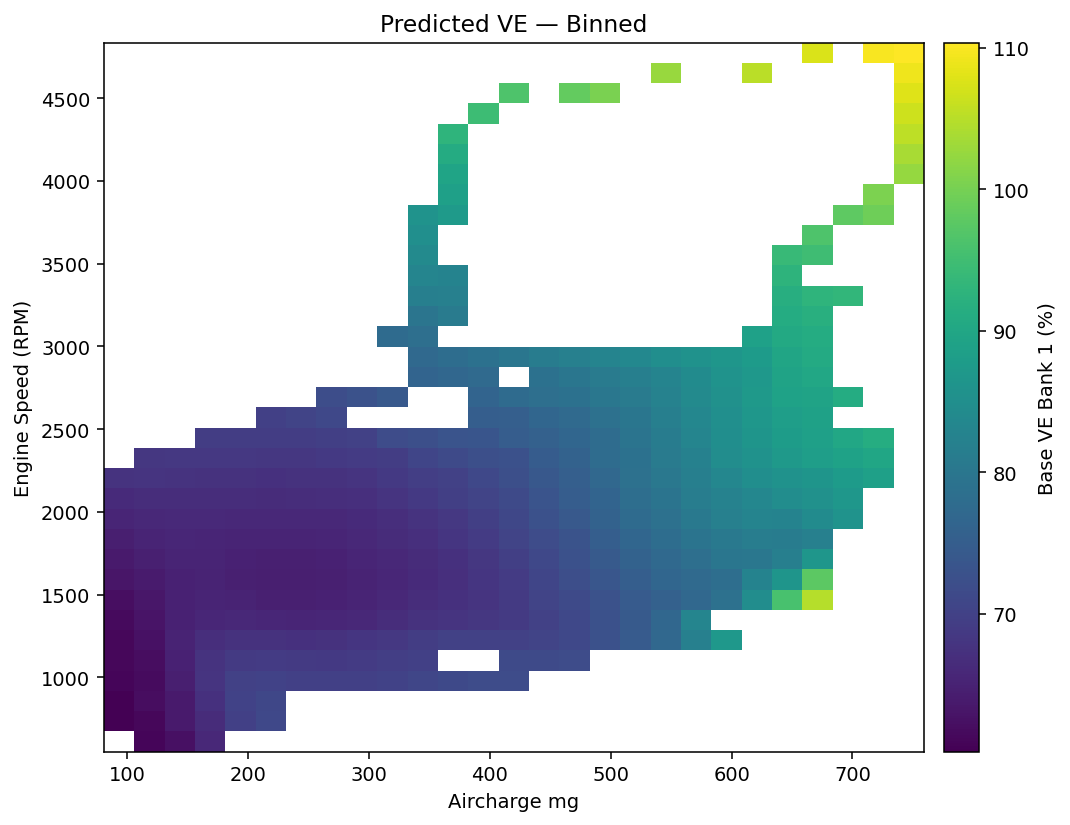

In [13]:
df = pd.DataFrame({
    "rpm": rpm,
    "aircharge": aircharge,
    "ve": Z
})

rpm_edges  = np.linspace(df.rpm.min(), df.rpm.max(), 36)
load_edges = np.linspace(df.aircharge.min(), df.aircharge.max(), 28)

grid = df.groupby([pd.cut(df.aircharge, load_edges),
                   pd.cut(df.rpm, rpm_edges)])["ve"].mean().unstack()

plt.figure(figsize=(8,6), dpi=140)
#                   X edges      Y edges      Z must be (len(Y)-1, len(X)-1)
pc = plt.pcolormesh(load_edges, rpm_edges, grid.values.T, shading="auto")
plt.colorbar(pc, pad=0.02).set_label("Base VE Bank 1 (%)")
plt.xlabel("Aircharge mg")          # <-- X axis
plt.ylabel("Engine Speed (RPM)")    # <-- Y axis
plt.title("Predicted VE — Binned")
plt.tight_layout()
plt.show()